In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import kagglehub
import time
from PIL import Image
import re

# Verify versions
print("PyTorch version:", torch.__version__)
assert torch.__version__ >= "1.12.0", "Requires PyTorch 1.12 or higher"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ========================
# Step 2: Dataset Handling (Fixed)
# ========================
class FacadesDataset(Dataset):
    def __init__(self, base_path, split='train'):
        self.path_a = os.path.join(base_path, f"{split}A")
        self.path_b = os.path.join(base_path, f"{split}B")
        
        # Get and sort files using natural sorting
        self.files_a = sorted([f for f in os.listdir(self.path_a) if f.endswith('.jpg')], 
                             key=lambda x: int(re.search(r'\d+', x).group()))
        self.files_b = sorted([f for f in os.listdir(self.path_b) if f.endswith('.jpg')], 
                             key=lambda x: int(re.search(r'\d+', x).group()))
        
        # Verify pairing using numeric prefixes
        for a, b in zip(self.files_a[:5], self.files_b[:5]):
            a_num = re.search(r'\d+', a).group()
            b_num = re.search(r'\d+', b).group()
            assert a_num == b_num, f"Mismatched pair: {a} vs {b}"

    def __len__(self):
        return len(self.files_a)

    def __getitem__(self, idx):
        # Load image pair using numeric matching
        img_a = Image.open(os.path.join(self.path_a, self.files_a[idx])).convert('RGB')
        img_b = Image.open(os.path.join(self.path_b, self.files_b[idx])).convert('RGB')
        
        # Apply paired transformations
        img_a, img_b = self.paired_transform(img_a, img_b)
        
        return img_a, img_b

    def paired_transform(self, img_a, img_b):
        """Joint transformations for both images"""
        # Resize
        resize = transforms.Resize((286, 286))
        img_a = resize(img_a)
        img_b = resize(img_b)
        
        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(img_a, output_size=(256, 256))
        img_a = transforms.functional.crop(img_a, i, j, h, w)
        img_b = transforms.functional.crop(img_b, i, j, h, w)
        
        # Random horizontal flip
        if torch.rand(1) > 0.5:
            img_a = transforms.functional.hflip(img_a)
            img_b = transforms.functional.hflip(img_b)
        
        # Convert to tensor and normalize
        img_a = transforms.functional.to_tensor(img_a) * 2 - 1
        img_b = transforms.functional.to_tensor(img_b) * 2 - 1
        
        return img_a, img_b

PyTorch version: 2.5.1+cu121
Using device: cuda


In [25]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super().__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super().__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True))
        self.dropout = nn.Dropout(dropout) if dropout else None

    def forward(self, x, skip_input):
        x = self.up(x)
        x = torch.cat((x, skip_input), 1)
        if self.dropout:
            x = self.dropout(x)
        return x

class GeneratorUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.down1 = UNetDown(3, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)
        
        # Decoder
        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)
        
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        
        # Decoder with skip connections
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        
        return self.final(u7)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(6, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [26]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

# Initialize models
generator = GeneratorUNet().to(device)
discriminator = Discriminator().to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Loss functions
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_pixel = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [28]:
# ========================
def sample_images(epoch, val_loader):
    generator.eval()
    with torch.no_grad():
        real_A, real_B = next(iter(val_loader))
        real_A = real_A.to(device)
        fake_B = generator(real_A)
        
        # Move to CPU and denormalize
        real_A = real_A.cpu().numpy().transpose(0, 2, 3, 1)
        real_B = real_B.cpu().numpy().transpose(0, 2, 3, 1)
        fake_B = fake_B.cpu().numpy().transpose(0, 2, 3, 1)
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow((real_A[0] + 1) / 2)
        axs[0].set_title("Input")
        axs[1].imshow((fake_B[0] + 1) / 2)
        axs[1].set_title("Generated")
        axs[2].imshow((real_B[0] + 1) / 2)
        axs[2].set_title("Real")
        plt.savefig(f"images/epoch_{epoch+1}.png")
        plt.close()

# Initialize datasets
dataset_path = kagglehub.dataset_download("balraj98/facades-dataset")

train_dataset = FacadesDataset(dataset_path, 'train')
val_dataset = FacadesDataset(dataset_path, 'test')

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Training parameters
epochs = 200
lambda_pixel = 100
checkpoint_interval = 10

# Create output directories
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

# Training loop
for epoch in range(epochs):
    start_time = time.time()
    gen_loss_accum = 0.0
    disc_loss_accum = 0.0
    
    for batch_idx, (real_A, real_B) in enumerate(train_loader):
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        # Generate fake images
        with torch.no_grad():
            fake_B = generator(real_A)
        
        # Real images
        pred_real = discriminator(real_A, real_B)
        loss_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
        
        # Fake images
        pred_fake = discriminator(real_A, fake_B.detach())
        loss_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
        
        # Total discriminator loss
        loss_D = (loss_real + loss_fake) * 0.5
        loss_D.backward()
        optimizer_D.step()
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        # Generate fake images
        fake_B = generator(real_A)
        
        # Adversarial loss
        pred_fake = discriminator(real_A, fake_B)
        loss_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake))
        
        # Pixel-wise loss
        loss_pixel = criterion_pixel(fake_B, real_B)
        
        # Total generator loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel
        loss_G.backward()
        optimizer_G.step()
        
        # Accumulate losses
        gen_loss_accum += loss_G.item()
        disc_loss_accum += loss_D.item()
    
    # ---------------------
    #  Epoch Statistics
    # ---------------------
    avg_gen_loss = gen_loss_accum / len(train_loader)
    avg_disc_loss = disc_loss_accum / len(train_loader)
    epoch_time = time.time() - start_time
    
    print(f"[Epoch {epoch+1}/{epochs}] "
          f"Time: {epoch_time:.2f}s | "
          f"G Loss: {avg_gen_loss:.4f} | "
          f"D Loss: {avg_disc_loss:.4f}")
    
    # Save samples and checkpoints
    if (epoch + 1) % checkpoint_interval == 0:
        sample_images(epoch, val_loader)
        torch.save(generator.state_dict(), f"saved_models/generator_{epoch+1}.pth")
        torch.save(discriminator.state_dict(), f"saved_models/discriminator_{epoch+1}.pth")

print("Training completed!")


[Epoch 1/200] Time: 28.06s | G Loss: 40.7139 | D Loss: 0.2255
[Epoch 2/200] Time: 28.29s | G Loss: 40.5166 | D Loss: 0.2248
[Epoch 3/200] Time: 27.73s | G Loss: 40.1458 | D Loss: 0.2183
[Epoch 4/200] Time: 27.96s | G Loss: 40.0337 | D Loss: 0.2016
[Epoch 5/200] Time: 28.03s | G Loss: 39.7882 | D Loss: 0.1789
[Epoch 6/200] Time: 27.89s | G Loss: 39.5273 | D Loss: 0.1758
[Epoch 7/200] Time: 27.91s | G Loss: 39.5839 | D Loss: 0.1447
[Epoch 8/200] Time: 27.98s | G Loss: 39.3678 | D Loss: 0.1717
[Epoch 9/200] Time: 27.98s | G Loss: 39.2389 | D Loss: 0.1480
[Epoch 10/200] Time: 28.00s | G Loss: 38.8724 | D Loss: 0.1632
[Epoch 11/200] Time: 27.99s | G Loss: 38.6132 | D Loss: 0.1350
[Epoch 12/200] Time: 28.06s | G Loss: 38.8984 | D Loss: 0.1204
[Epoch 13/200] Time: 28.00s | G Loss: 38.2934 | D Loss: 0.1677
[Epoch 14/200] Time: 27.94s | G Loss: 38.5891 | D Loss: 0.1399
[Epoch 15/200] Time: 27.97s | G Loss: 37.7360 | D Loss: 0.1228
[Epoch 16/200] Time: 27.94s | G Loss: 38.2013 | D Loss: 0.1282
[

Final evaluation results:


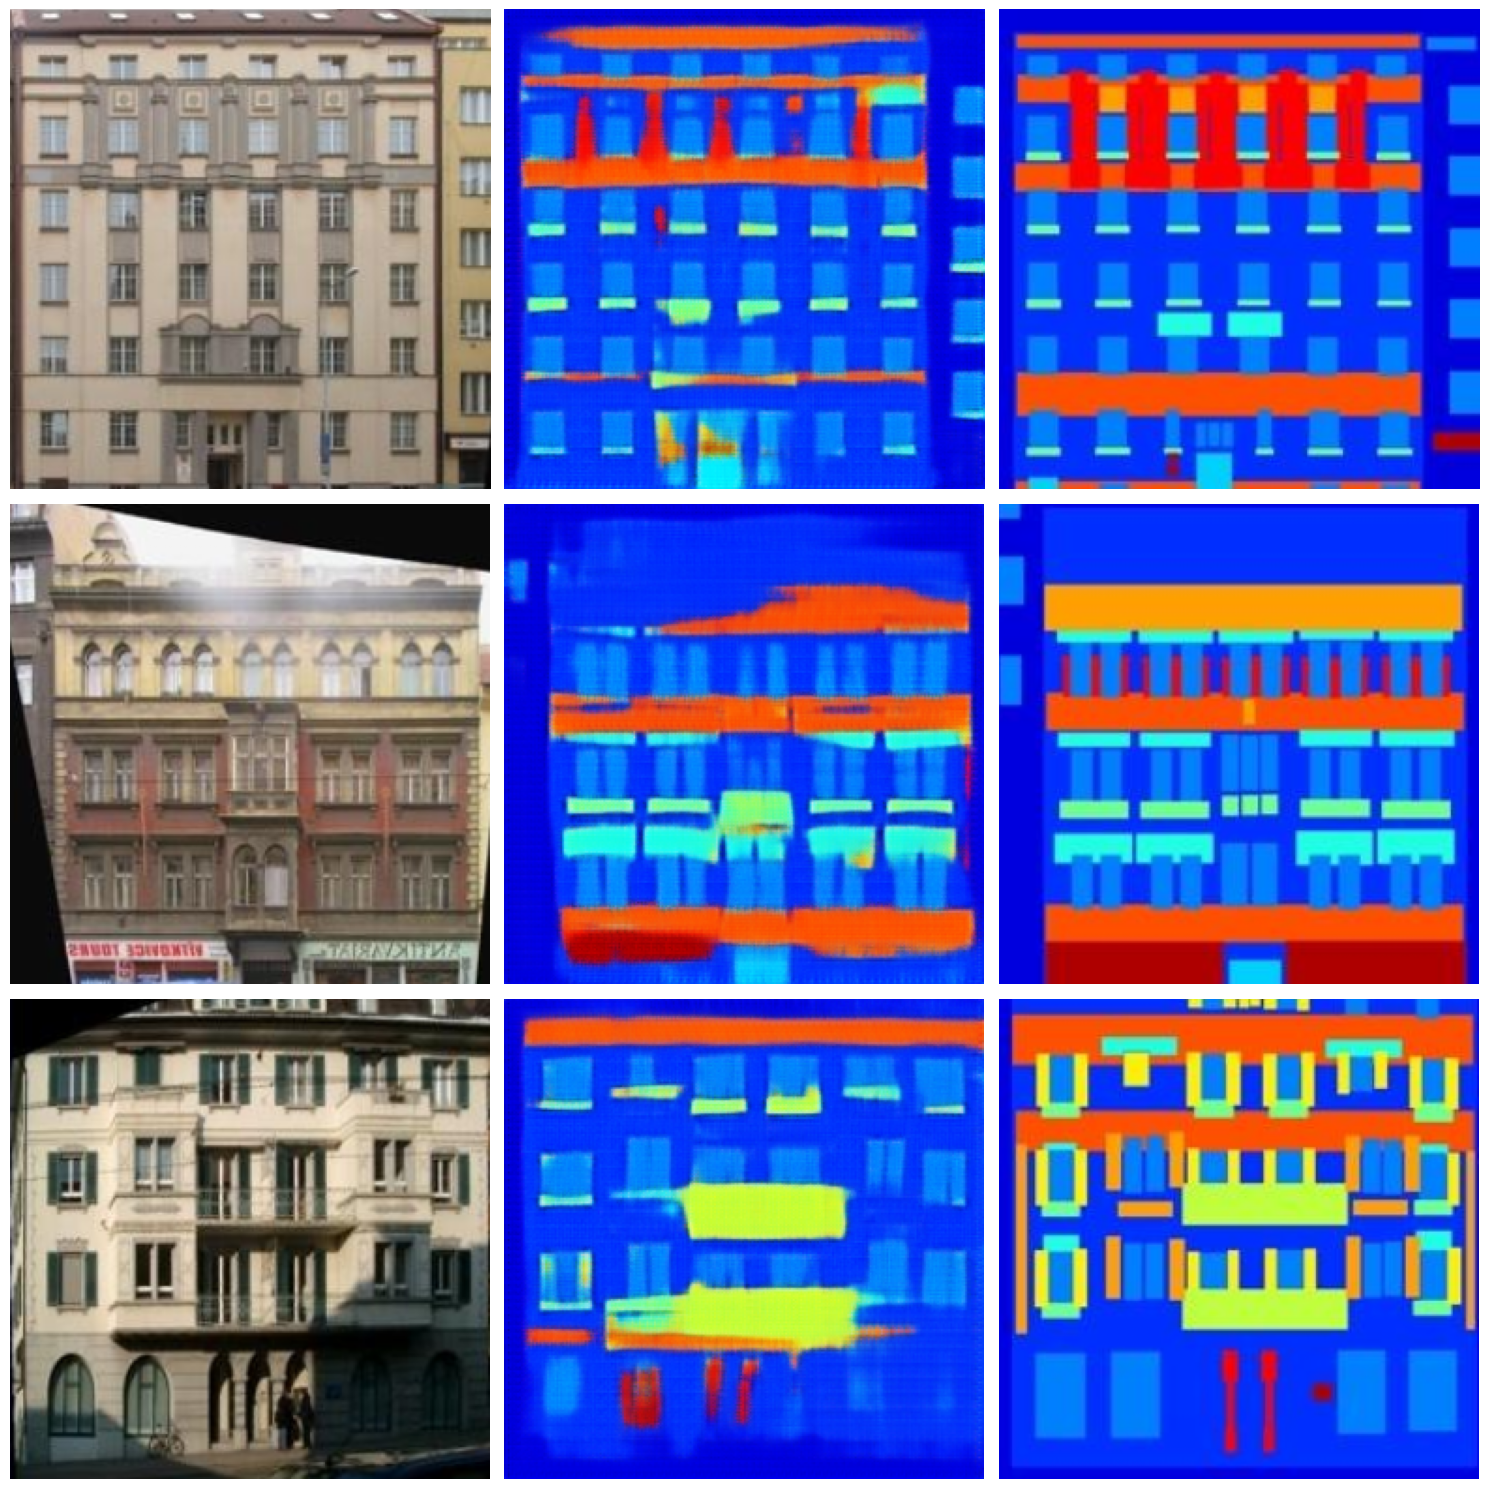

In [29]:
def evaluate_model(model, dataloader, num_samples=3):
    model.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        
        for i, (real_A, real_B) in enumerate(dataloader):
            if i >= num_samples:
                break
                
            real_A = real_A.to(device)
            fake_B = model(real_A)
            
            # Denormalize and convert to numpy
            real_A = (real_A.cpu().numpy().transpose(0, 2, 3, 1) + 1) / 2
            fake_B = (fake_B.cpu().numpy().transpose(0, 2, 3, 1) + 1) / 2
            real_B = (real_B.cpu().numpy().transpose(0, 2, 3, 1) + 1) / 2
            
            axs[i,0].imshow(real_A[0])
            axs[i,0].axis('off')
            axs[i,1].imshow(fake_B[0])
            axs[i,1].axis('off')
            axs[i,2].imshow(real_B[0])
            axs[i,2].axis('off')
            
        plt.tight_layout()
        plt.show()

print("Final evaluation results:")
evaluate_model(generator, val_loader)